In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from utils import make_table, fazer_testes
from time import time

In [3]:
sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

@dataclass
class Item:
    valor: int
    peso: int
    is_otimo: bool

    @property
    def custo_beneficio(self):
        return self.valor / self.peso

BeneficioMaximo, Capacidade = int, int


def get_data(cat: int, size: int) -> tuple[BeneficioMaximo, Capacidade, list[Item]]:
    path = "dataset/{}/knapPI_{}_{}_1000_1"

    with open(path.format("large_scale", cat, size), "r") as f:
        get_line_values = lambda: list(map(int, f.readline().split()))
        # Pega o resultado ótimo
        with open(path.format("large_scale-optimum", cat, size), "r") as g:
            beneficio_maximo = int(g.read())

        # Primeira Linha: número de itens `n`e capacidade da mochila
        n, capacidade = get_line_values()

        # Próximas `n`linhas: valor e peso de cada item
        valores, pesos = [list(i) for i in zip(*[get_line_values() for _ in range(n)])]

        # Última linha: vetor de booleanos indicando quais itens compõe uma solução ótima
        solucoes_otimas = get_line_values()

        itens = [
            Item(v, p, bool(otimo))
            for v, p, otimo in zip(valores, pesos, solucoes_otimas)
        ]

    return beneficio_maximo, capacidade, itens


### Analise do dataset

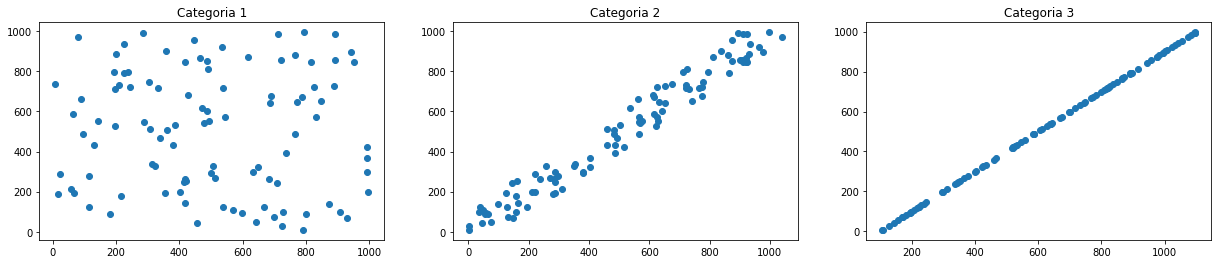

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(21, 4))

for cat in [1, 2, 3]:
    itens = get_data(cat, size=100)[2]

    valores = [i.valor for i in itens]
    pesos = [i.peso for i in itens]

    ax[cat - 1].scatter(valores, pesos)
    ax[cat - 1].set_title(f"Categoria {cat}")


### Abordagem Gulosa

##### Priorizando o número de items a serem inseridos

In [5]:
def perf_aprox_gulosa_max_numero_itens(categoria, size):
    beneficio_maximo, capacidade, itens = get_data(categoria, size)

    v, w = 0, 0

    for item in sorted(itens, key=lambda i: i.peso):
        if (w + item.peso) > capacidade:
            break
        w += item.peso
        v += item.valor

    desempenho = v / beneficio_maximo
    return desempenho

Precisão do algoritmo comparado ao resultado ótimo (%)
╒═════════════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤═════════╤═════════╕
│             │  100  │  200  │  500  │  1000  │  2000  │  5000  │  10000  │  Média  │
╞═════════════╪═══════╪═══════╪═══════╪════════╪════════╪════════╪═════════╪═════════╡
│ Categoria 1 │ 0.95  │ 0.956 │ 0.873 │ 0.872  │ 0.884  │ 0.888  │  0.879  │   0.9   │
├─────────────┼───────┼───────┼───────┼────────┼────────┼────────┼─────────┼─────────┤
│ Categoria 2 │ 0.569 │ 0.638 │ 0.68  │  0.68  │ 0.663  │ 0.631  │  0.654  │  0.645  │
├─────────────┼───────┼───────┼───────┼────────┼────────┼────────┼─────────┼─────────┤
│ Categoria 3 │ 0.991 │ 0.982 │ 0.997 │ 0.999  │ 0.997  │ 0.999  │    1    │  0.995  │
├─────────────┼───────┼───────┼───────┼────────┼────────┼────────┼─────────┼─────────┤
│ Média       │ 0.837 │ 0.859 │ 0.85  │  0.85  │ 0.848  │ 0.839  │  0.844  │  0.847  │
╘═════════════╧═══════╧═══════╧═══════╧════════╧════════╧════════╧═════════

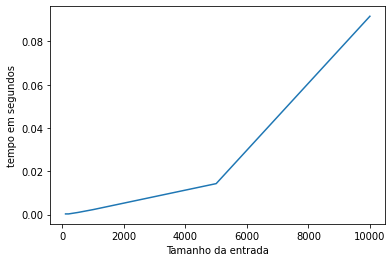

In [36]:
results_1, times_1 = fazer_testes(perf_aprox_gulosa_max_numero_itens, repeticoes=20)
print("Precisão do algoritmo comparado ao resultado ótimo (%)")
make_table(results_1)

for size, tempos in times_1.items():
    media_t = sum(tempos) / len(tempos)
    times_1[size] = media_t


plt.plot(times_1.keys(), times_1.values())
plt.ylabel("tempo em segundos")
plt.xlabel("Tamanho da entrada")

plt.show()

##### Priorizando os itens de melhor relação de benefício/custo

In [7]:
def perf_aprox_gulosa_beneficio_custo(categoria, size):
    beneficio_maximo, capacidade, itens = get_data(categoria, size)

    v, w = 0, 0
    for item in sorted(itens, key=lambda i: i.valor / i.peso, reverse=True):
        if (w + item.peso) < capacidade:
            w += item.peso
            v += item.valor

    desempenho = v / beneficio_maximo
    return desempenho

Precisão do algoritmo comparado ao resultado ótimo (%)
╒═════════════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤═════════╤═════════╕
│             │  100  │  200  │  500  │  1000  │  2000  │  5000  │  10000  │  Média  │
╞═════════════╪═══════╪═══════╪═══════╪════════╪════════╪════════╪═════════╪═════════╡
│ Categoria 1 │ 0.964 │ 0.999 │ 0.999 │ 0.998  │ 0.999  │   1    │    1    │  0.994  │
├─────────────┼───────┼───────┼───────┼────────┼────────┼────────┼─────────┼─────────┤
│ Categoria 2 │ 0.982 │ 0.982 │ 0.997 │ 0.999  │ 0.999  │   1    │    1    │  0.994  │
├─────────────┼───────┼───────┼───────┼────────┼────────┼────────┼─────────┼─────────┤
│ Categoria 3 │ 0.991 │ 0.982 │ 0.997 │ 0.999  │ 0.997  │ 0.999  │    1    │  0.995  │
├─────────────┼───────┼───────┼───────┼────────┼────────┼────────┼─────────┼─────────┤
│ Média       │ 0.979 │ 0.988 │ 0.998 │ 0.999  │ 0.998  │   1    │    1    │  0.994  │
╘═════════════╧═══════╧═══════╧═══════╧════════╧════════╧════════╧═════════

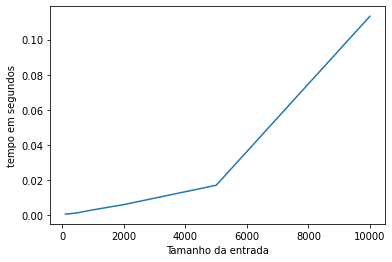

In [37]:
results_2, times_2 = fazer_testes(perf_aprox_gulosa_beneficio_custo, repeticoes=20)

print("Precisão do algoritmo comparado ao resultado ótimo (%)")
print(make_table(results_2))

print("Tempos de execução em segundos")

for size, tempos in times_2.items():
    media_t = sum(tempos) / len(tempos)
    times_2[size] = media_t


plt.plot(times_2.keys(), times_2.values())
# plt.xticks(times_2.keys())
plt.ylabel("tempo em segundos")
plt.xlabel("Tamanho da entrada")
plt.show()

### Abordagem por Programação Dinâmica

In [13]:
def abordagem_prog_dinamica(categoria, size):
    beneficio_maximo, W, itens = get_data(categoria, size)
    # array que guarda os resultados ótimos para mochilas de capacidade indo de 0 a W
    mochilas = [0 for _ in range(W + 1)]

    for item in itens:
        # index do peso das mochilas anteriores que cabem na mochila
        w_validos = [w for w in range(W) if item.peso + w <= W]

        for w in w_validos:
            mochilas[w] = max(mochilas[w], mochilas[w + item.peso] + item.valor)
    return mochilas[0]

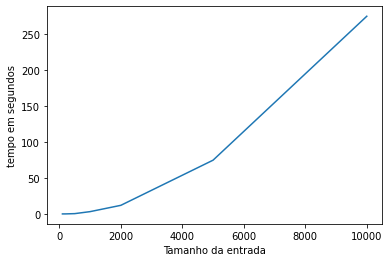

In [33]:
from time import time

tempos = []
repeticoes = 1
for size in sizes:
    tempo_size = []
    for _ in range(repeticoes):
        start = time()
        abordagem_prog_dinamica(3, size)
        end = time()

        tempo_size.append(end - start)
    
    tempos.append(sum(tempo_size)/repeticoes)


plt.plot(sizes, tempos)
plt.plot(times_1.keys(), times_1.values())
plt.plot(times_2.keys(), times_2.values())
plt.ylabel("tempo em segundos")
plt.xlabel("Tamanho da entrada")

plt.show()